# Zcash Observatory data

Mitchell Krawiec-Thayer and Pranav Thirunavukkarasu

April 2020

Observatory R & D at [Insight](https://www.insightconsensus.com) supported by the [Zcash Foundation](https://grants.zfnd.org/proposals/21786689)

## Analysis Parameters

In [1]:
path_to_block_data = 'blocks_20200408.csv'
output_filename = 'augmented_data.csv'
block_time_s = 75
sync_cutoff = 10000 #ms
q_save_output = 1

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [3]:
df = pd.read_csv('blocks_20200408.csv') # Import to data frame
df.describe() # High level summary of the data set

,block_height,miner_time,valid_time
count,10281.000000,1.028100e+04,1.028100e+04
mean,781900.051649,1.585770e+09,1.585770e+12
std,3434.295589,2.587229e+05,2.587500e+08
min,776372.000000,1.585354e+09,1.585354e+12
25%,778941.000000,1.585547e+09,1.585547e+12
50%,781506.000000,1.585741e+09,1.585741e+12
75%,785262.000000,1.586023e+09,1.586024e+12
max,787835.000000,1.586218e+09,1.586219e+12


In [4]:
df.head() # Take a peeke to make sure it imported correctly

,block_height,block_hash,prev_hash,miner_target,miner_time,valid_time,transaction_hashes,inv_timestamps
0,777350.0,00000000014a976f53c53c63a2d52c0246e4c9ecf260b9...,0000000001afacebda04eb4ef20b46b34715d042473409...,0000000002ffff00000000000000000000000000000000...,1.585428e+09,1.585428e+12,269090c8fa46f72c3090803a7ec5231d3e3f73c0035f3d...,1585427780187;1585427780195;1585427780309;1585...
1,776540.0,00000000016dbb649d01642fb8603d9cfb3337a38c3c36...,00000000008855524979caa571b3fe7031d3e769eb6190...,0000000002fc4d00000000000000000000000000000000...,1.585366e+09,1.585366e+12,bd093b58b615184b82c4d7d4c1395cf0e6477470830fa3...,1585366448977;1585366448944;1585366449144;1585...
2,777066.0,00000000007826f5d75ea2268aa6703ff3087a1419daa7...,00000000007b4d4a898c18c291243e39998e52bcf67795...,0000000002e0d600000000000000000000000000000000...,1.585406e+09,1.585406e+12,09821279cf3b13cac66fe4b6e57f3778f4621cee083a02...,1585406005599;1585406005554;1585406005524;1585...
3,777264.0,00000000031fac7a7d902a87dc887375b83fd64466304a...,00000000002fc315a0c67eb4b1c26e7c8b6f5055e3f1cf...,00000000033fdd00000000000000000000000000000000...,1.585422e+09,1.585422e+12,0e61aaff225ead8a7d175853a2a9c161e1765bae525bbf...,1585421660806;1585421660865;1585421660793;1585...
4,777150.0,0000000002a6698519dc8abf12e82d2d74e4d4518243d4...,0000000000bb617c3c9603ba991dce9feb5df9265697ed...,0000000002c29f00000000000000000000000000000000...,1.585412e+09,1.585412e+12,a08776d8cdeafbc4f675fcaf5a9dd73bc509249fff6d25...,1585412301058;1585412301031;1585412301126;1585...


## Feature Engineering

Add a handful of calculated columns

In [5]:
fork_heights = set()
dupe_count_buffer = []
apparent_latency_buffer = []
peer_count_buffer = []
raw_prop_buffer = []
prop_buffer = []
txn_count_buffer = []
bounded_times_list = []

for r in range(len(df)):
    
    # Grab height
    this_height = df.iloc[r].block_height
    
    # How many versions were received at this_height?
    this_count = len(df[df['block_height'] == this_height])
    dupe_count_buffer.append(this_count)
    if this_count > 1:
        fork_heights.add(int(this_height)) # note this makes duplicates, so remember to unique() later

    raw_timestamps = df.iloc[r].inv_timestamps
    # If multiple peers, inv_timestamps is parsed as a string, and must be split into list of integers
    if isinstance(raw_timestamps, str):
        peer_timestamps = [int(i) for i in raw_timestamps.split(';')] # split up the timestamps
        peer_count_buffer.append(int(len(peer_timestamps))) # record peer count
        apparent_latency_buffer.append(int(min(peer_timestamps) - 1000*df.iloc[r].miner_time))
        raw_prop_time = np.max(peer_timestamps)-np.min(peer_timestamps)
        raw_prop_buffer.append(raw_prop_time)
        if raw_prop_time < sync_cutoff:
            prop_buffer.append(raw_prop_time)
            bounded_times = peer_timestamps
        else:
            # Throw out the high timestamp and try again. This a temporary fix
            peer_offset_removed = [x - min(peer_timestamps) for x in peer_timestamps]
            bounded_times = [p for p in peer_offset_removed if p < sync_cutoff]
            prop_buffer.append(np.max(bounded_times) - np.min(bounded_times))
    else:
        if np.isnan(raw_timestamps):
            # Did not catch this live from any peers
            peer_timestamps = np.nan 
            peer_count_buffer.append(np.nan)
            raw_prop_buffer.append(np.nan)
            prop_buffer.append(np.nan)
            apparent_latency_buffer.append(np.nan)
            bounded_times = (np.nan)
        else:
            # Caught one copy, parsed as a float
            peer_timestamps = int(raw_timestamps)
            peer_count_buffer.append(1)
            raw_prop_buffer.append(np.nan)
            prop_buffer.append(np.nan)
            apparent_latency_buffer.append(peer_timestamps - 1000*df.iloc[r].miner_time)
            bounded_times = (peer_timestamps)
        
    bounded_times_list.append(bounded_times)
        
    txn_list = str(df.iloc[r].transaction_hashes)
    if isinstance(txn_list, str):
        txn_count_buffer.append(len(txn_list.split(';')))
    else:
        txn_count_buffer.append(1)
        
df['dupe_count'] = dupe_count_buffer
df['apparent_latency_ms'] = apparent_latency_buffer
df['peer_count'] = peer_count_buffer
df['raw_prop_ms'] = raw_prop_buffer
df['prop_envelope_ms'] = prop_buffer
df['txn_count'] = txn_count_buffer
df['bounded_p2p_times'] = bounded_times_list

Calculate block differences based on the **miner-reported timestamp**. Remember that these can and often are spoofed.

In [6]:
# Calculate block times
miner_time_diff_buffer = []

for r in range(len(df)):

    this_height = df.iloc[r].block_height
    prev_indices = df.index[df['block_height'] == this_height-1].tolist()

    if len(prev_indices) == 0: 
        # If we didn't record previous block, then NaN and move on
        miner_time_diff_buffer.append(np.nan)
    else:
        # Get the index of (any one version of) the previous block
        if len(prev_indices) == 1:
            use_index = prev_indices
        else:
            use_index = int(min(prev_indices)) # pick only one index
            
        last_miner_time = int(df.iloc[use_index].miner_time) # miner time from last block
        this_miner_time = df.iloc[r].miner_time # miner time from this block
        miner_time_diff = (this_miner_time - last_miner_time) # difference
        miner_time_diff_buffer.append(miner_time_diff) # record

df['miner_reported_time_diff'] = miner_time_diff_buffer

Now calculate the **REAL** block time based on observatory timestamps ("bounded_p2p_timestamps" column!)

In [7]:
# Calculate block times
real_block_time_buffer = []
bounded_times_list = []

for r in range(len(df)):

    this_height = df.iloc[r].block_height
    prev_indices = df.index[df['block_height'] == this_height-1].tolist()

    if len(prev_indices) == 0: 
        # If we didn't record previous block, then NaN and move on
        miner_time_diff_buffer.append(np.nan)
    else:
        # Get the index of (any one version of) the previous block
        if len(prev_indices) == 1:
            use_index = prev_indices
        else:
            use_index = int(min(prev_indices)) # pick only one index
            
        last_real_raw = df.iloc[use_index].bounded_p2p_times # sometimes a list, sometimes float, sometimes NaN
        this_real_raw = df.iloc[r].bounded_p2p_times # sometimes a list, sometimes float, sometimes NaN
        
        last_real_timestamp = ????? # Can't get this line to handle list/float/NaN smoothly
        this_real_timestamp = ????? # Can't get this line to handle list/float/NaN smoothly
            
        real_time_diff = (this_real_time - last_real_time)/1000
        real_block_time_buffer.append(real_time_diff)
        
df['real_block_time'] = real_block_time_buffer

SyntaxError: invalid syntax (<ipython-input-7-fe1c4ce88a1b>, line 23)

In [8]:
df.sort_values(by='block_height').head()

,block_height,block_hash,prev_hash,miner_target,miner_time,valid_time,transaction_hashes,inv_timestamps,dupe_count,apparent_latency_ms,peer_count,raw_prop_ms,prop_envelope_ms,txn_count,bounded_p2p_times,miner_reported_time_diff
962,776372.0,0000000002dffd1620d240c2645ae19ef6f6e65d9549a8...,000000000001b0212b77e7a36b3db3a6339b1101c01047...,0000000003223500000000000000000000000000000000...,1.585354e+09,1.585354e+12,ab73373b9de381ea9343b1b565bc7728d5f6a2b7be9cb8...,1585353675885;1585353675718;1585353675847;1585...,1,19660.0,7.0,264.0,264.0,5,"[1585353675885, 1585353675718, 1585353675847, ...",NaN
729,776373.0,0000000000af794152926dce4bf5535e96013917239d03...,0000000002dffd1620d240c2645ae19ef6f6e65d9549a8...,00000000031d9300000000000000000000000000000000...,1.585354e+09,1.585354e+12,c22114dbe83165623a1d720faaab2dc21d9733cdda120c...,1585353772817;1585353772934;1585353772817;1585...,1,16645.0,7.0,367.0,367.0,4,"[1585353772817, 1585353772934, 1585353772817, ...",100.0
667,776374.0,00000000003add8a649ff60f94d3f08eb492d554d51ce4...,0000000000af794152926dce4bf5535e96013917239d03...,00000000031d5100000000000000000000000000000000...,1.585354e+09,1.585354e+12,126a7036a71f1d367f7eb8dc4f5bb685aa8da25a080dc3...,1585353936366;1585353936170;1585353936297;1585...,1,73137.0,10.0,284.0,284.0,4,"[1585353936366, 1585353936170, 1585353936297, ...",107.0
15,776375.0,00000000019d916bb8ea02167b41eef51eef0d4875084b...,00000000003add8a649ff60f94d3f08eb492d554d51ce4...,0000000003121700000000000000000000000000000000...,1.585354e+09,1.585354e+12,40ffbb2d0d74c906f27be2ef9444255945899b6afb7778...,1585353980845;1585353980979;1585353981065;1585...,1,18845.0,8.0,220.0,220.0,8,"[1585353980845, 1585353980979, 1585353981065, ...",99.0
363,776376.0,00000000000a0432d3a44c4699822e72d77a3a63435ce3...,00000000019d916bb8ea02167b41eef51eef0d4875084b...,0000000002e24d00000000000000000000000000000000...,1.585354e+09,1.585354e+12,0e0ddf98661995bab8ca2feb36ae7f72177d95df16a441...,1585354056452;1585354056217;1585354056367;1585...,1,15217.0,7.0,235.0,235.0,4,"[1585354056452, 1585354056217, 1585354056367, ...",79.0


In [9]:
if q_save_output:
    df.to_csv(output_filename, index=False)

## Visualizations

### When did we encounter forks?

Encountered 30 forks, during 10224 blocks of operation
                             (213 hours)
                             (9 days)
This represents a 0.29% fork rate


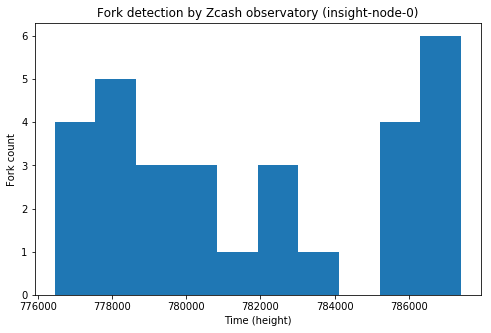

In [10]:
uptime_blocks = np.count_nonzero(~np.isnan(df.peer_count))
print('Encountered ' + str(len(fork_heights)) + ' forks, during ' + str(uptime_blocks) + ' blocks of operation')
print('                             (' + str(round(uptime_blocks*block_time_s/60/60)) + ' hours)')
print('                             (' + str(round(uptime_blocks*block_time_s/60/60/24)) + ' days)')
print('This represents a ' + str(round(len(fork_heights)/uptime_blocks*100,2)) + '% fork rate')

height_hist = plt.figure(figsize=(8,5), facecolor='w')
plt.hist(list(fork_heights));
plt.xlabel('Time (height)')
plt.ylabel('Fork count')
plt.title('Fork detection by Zcash observatory (insight-node-0)');

## Comparing miner timestamps against actual receipt
Please note that the miner-reported timestamp is a semi-arbitrary value selected by the miner when they initially generate the block headers. You should not assume that ANY of them are correct.

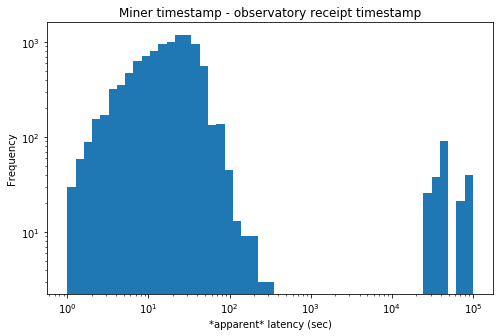

In [11]:
height_hist = plt.figure(figsize=(8,5), facecolor='w')
plt.hist(df.apparent_latency_ms/1000, bins=np.logspace(np.log10(1),np.log10(1e5), 50));
plt.yscale('log')
plt.xscale('log')
plt.xlabel('*apparent* latency (sec)')
plt.ylabel('Frequency')
plt.title('Miner timestamp - observatory receipt timestamp');

## Propagation time

Text(0.5, 1.0, 'Observed block propagation time (insight-node-0)')

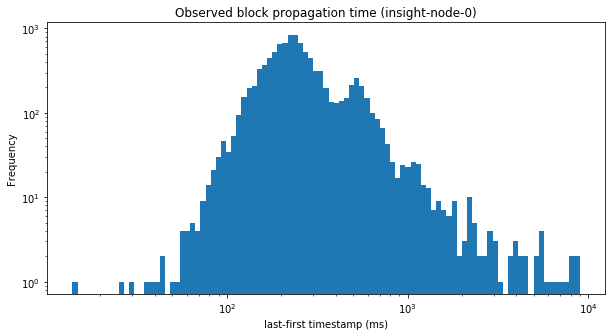

In [12]:
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(df['prop_envelope_ms'], bins=np.logspace(np.log10(min(df['prop_envelope_ms'][df['prop_envelope_ms']>0])),np.log10(max(df['prop_envelope_ms'])), 100) );
plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (insight-node-0)')

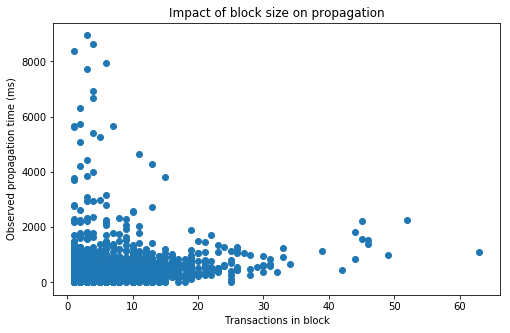

In [13]:
# How does the observed propagation envelope depend on the number of transactions in a block
peer_prop_scatter = plt.figure(figsize=(8,5), facecolor='w')
plt.scatter(df['txn_count'], df['prop_envelope_ms'])
plt.xlabel('Transactions in block')
plt.ylabel('Observed propagation time (ms)')
plt.yscale('linear')
plt.xscale('linear')
plt.title('Impact of block size on propagation');

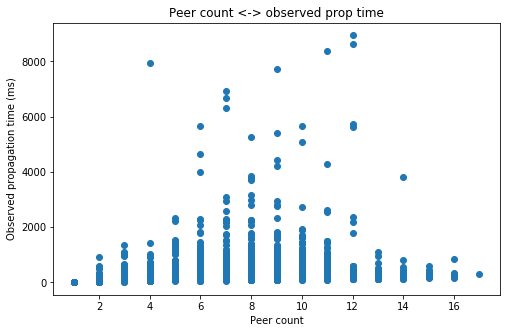

In [14]:
# How does the observed propagation envelope depend on the number of peers that we hear the block from
peer_prop_scatter = plt.figure(figsize=(8,5), facecolor='w')
plt.scatter(df['peer_count'], df['prop_envelope_ms'])
plt.xlabel('Peer count')
plt.ylabel('Observed propagation time (ms)')
plt.title('Peer count <-> observed prop time');

Note that that we can see how fast remote nodes are syncing, based on when they ask for blocks

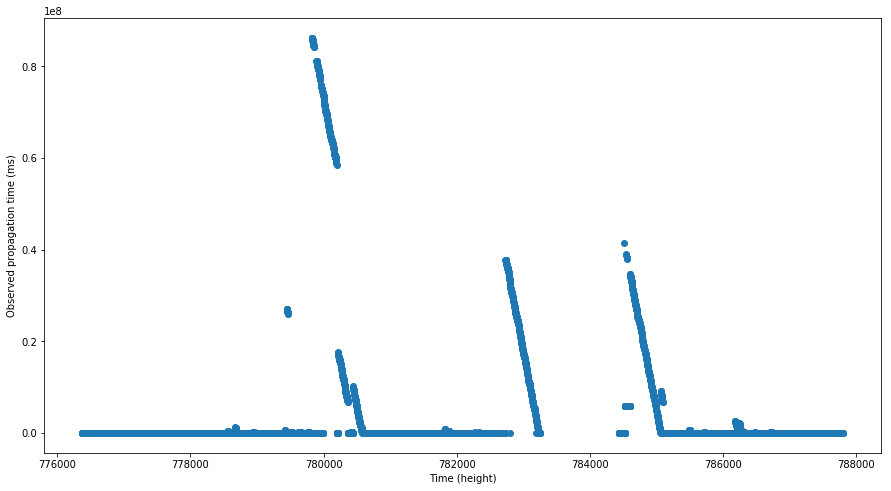

In [15]:
peer_prop_scatter = plt.figure(figsize=(15,8), facecolor='w')
plt.scatter(df['block_height'], df['raw_prop_ms'])
plt.xlabel('Time (height)')
plt.ylabel('Observed propagation time (ms)')
plt.title('');